# Travel Recommendation System - Research Notebook
## Predicting Tourist Enjoyment Scores in Sri Lanka

**Project Goal:** Train an XGBoost Regressor to predict enjoyment scores (0-10) based on user preferences and location attributes.

**Dataset:** Synthetic tourist interactions data from Sri Lanka tourism locations.

**Author:** Senior Data Scientist  
**Date:** November 22, 2025

---

## Table of Contents
1. **Data Loading** - Import and prepare datasets
2. **Exploratory Data Analysis (EDA)** - Understand data distributions and relationships
3. **Feature Engineering** - Prepare features for modeling
4. **Model Training** - Train XGBoost Regressor with hyperparameter tuning
5. **Evaluation & Interpretation** - Validate model performance and extract insights

---
# Phase 1: Data Loading

In this phase, we will:
- Import necessary libraries for data manipulation, visualization, and machine learning
- Load the training interactions dataset and locations metadata
- Perform initial data inspection to understand structure and data types

In [38]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


### Load Datasets

We load two CSV files:
1. **training_interactions.csv** - Contains user-location interaction records with enjoyment scores
2. **locations_metadata.csv** - Contains additional metadata about each location

These files are located in the `../data/raw/` directory relative to this notebook.

In [39]:
# Define data paths
data_path = Path('../data/raw')
training_file = data_path / 'training_interactions.csv'
metadata_file = data_path / 'locations_metadata.csv'

# Load datasets
df_train = pd.read_csv(training_file)
df_metadata = pd.read_csv(metadata_file)

print(f"✅ Training Data Shape: {df_train.shape}")
print(f"✅ Metadata Shape: {df_metadata.shape}")
print(f"\n📊 Training Data Preview:")
df_train.head()

✅ Training Data Shape: (9000, 16)
✅ Metadata Shape: (80, 8)

📊 Training Data Preview:


,User_ID,User_Archetype,u_hist,u_adv,u_nat,u_rel,Location_Name,l_hist,l_adv,l_nat,l_rel,l_outdoor,l_lat,l_lng,c_raining,ENJOYMENT_SCORE
0,U0001,Backpacker,0.08,0.72,0.54,0.23,Pigeon Island,0.1,0.7,0.9,0.3,1,8.7167,81.2000,1,0.0
1,U0001,Backpacker,0.08,0.72,0.54,0.23,Royal Botanical Gardens,0.3,0.1,0.9,0.8,1,7.2697,80.5967,0,4.2
2,U0001,Backpacker,0.08,0.72,0.54,0.23,Hanthana Mountain Range,0.1,0.8,0.8,0.1,1,7.2586,80.6286,0,4.0
3,U0001,Backpacker,0.08,0.72,0.54,0.23,Weligama Surf Break,0.0,0.9,0.4,0.3,1,5.9667,80.4333,0,4.7
4,U0001,Backpacker,0.08,0.72,0.54,0.23,Ravana Falls,0.2,0.3,0.8,0.5,1,6.8417,81.0500,0,3.6


### Initial Data Inspection

Understanding the dataset structure, data types, and checking for missing values is crucial before proceeding with analysis.

In [40]:
# Dataset Information
print("=" * 80)
print("TRAINING INTERACTIONS DATASET INFO")
print("=" * 80)
df_train.info()

print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
print(df_train.describe())

print("\n" + "=" * 80)
print("MISSING VALUES CHECK")
print("=" * 80)
missing_values = df_train.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "✅ No missing values found!")

print("\n" + "=" * 80)
print("TARGET VARIABLE (ENJOYMENT_SCORE) RANGE")
print("=" * 80)
print(f"Min: {df_train['ENJOYMENT_SCORE'].min():.2f}")
print(f"Max: {df_train['ENJOYMENT_SCORE'].max():.2f}")
print(f"Mean: {df_train['ENJOYMENT_SCORE'].mean():.2f}")
print(f"Median: {df_train['ENJOYMENT_SCORE'].median():.2f}")

TRAINING INTERACTIONS DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User_ID          9000 non-null   object 
 1   User_Archetype   9000 non-null   object 
 2   u_hist           9000 non-null   float64
 3   u_adv            9000 non-null   float64
 4   u_nat            9000 non-null   float64
 5   u_rel            9000 non-null   float64
 6   Location_Name    9000 non-null   object 
 7   l_hist           9000 non-null   float64
 8   l_adv            9000 non-null   float64
 9   l_nat            9000 non-null   float64
 10  l_rel            9000 non-null   float64
 11  l_outdoor        9000 non-null   int64  
 12  l_lat            9000 non-null   float64
 13  l_lng            9000 non-null   float64
 14  c_raining        9000 non-null   int64  
 15  ENJOYMENT_SCORE  9000 non-null   float64
dtypes: float64(11), int64(2),

---
# Phase 2: Exploratory Data Analysis (EDA)

EDA is critical to understand:
- **Target Distribution** - Is our enjoyment score balanced or skewed?
- **Feature Correlations** - Which user preferences and location attributes correlate with enjoyment?
- **Data Patterns** - Are some locations more popular than others (long tail distribution)?

These insights will inform our feature engineering and model selection decisions.

### 2.1 Target Distribution Analysis

The distribution of our target variable (ENJOYMENT_SCORE) is crucial:
- **Normal distribution** suggests linear regression could work well
- **Skewed distribution** might require transformation or tree-based models (like XGBoost)
- **Understanding the range** helps us set realistic performance expectations

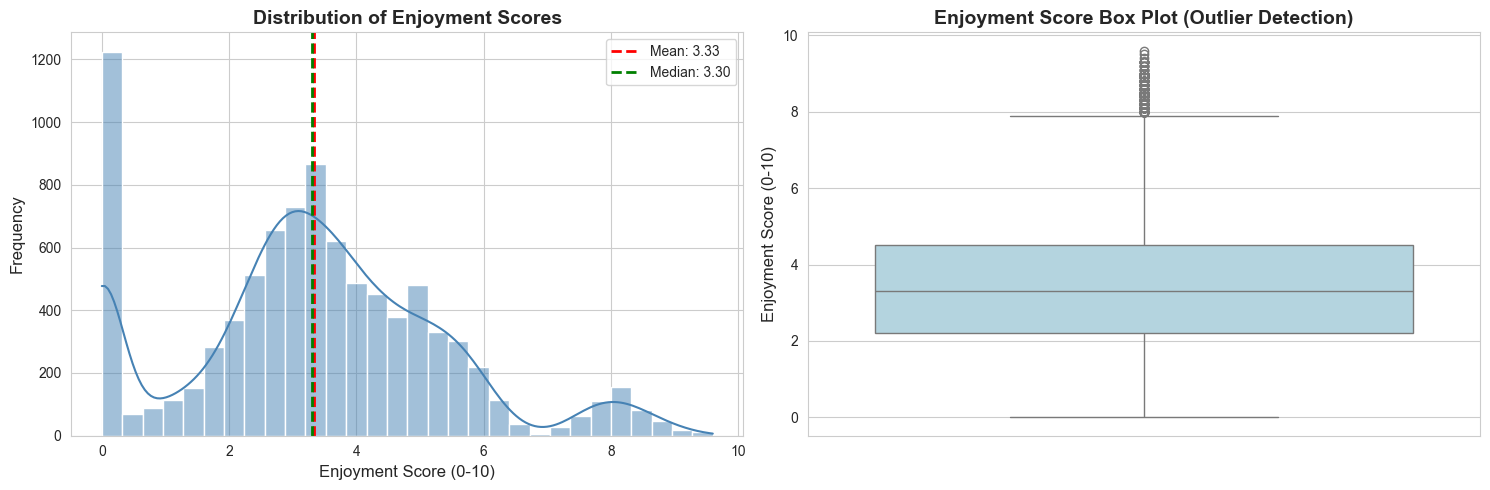


📊 DISTRIBUTION ANALYSIS:
Skewness: 0.291
  → Distribution is approximately symmetric (balanced)

Kurtosis: 0.081
  → Distribution has normal tail behavior


In [41]:
# Target Variable Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution plot
sns.histplot(df_train['ENJOYMENT_SCORE'], bins=30, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Enjoyment Scores', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Enjoyment Score (0-10)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df_train['ENJOYMENT_SCORE'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_train["ENJOYMENT_SCORE"].mean():.2f}')
axes[0].axvline(df_train['ENJOYMENT_SCORE'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df_train["ENJOYMENT_SCORE"].median():.2f}')
axes[0].legend()

# Box plot
sns.boxplot(y=df_train['ENJOYMENT_SCORE'], ax=axes[1], color='lightblue')
axes[1].set_title('Enjoyment Score Box Plot (Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Enjoyment Score (0-10)', fontsize=12)

plt.tight_layout()
plt.show()

# Statistical analysis
from scipy import stats
skewness = stats.skew(df_train['ENJOYMENT_SCORE'])
kurtosis = stats.kurtosis(df_train['ENJOYMENT_SCORE'])

print("\n📊 DISTRIBUTION ANALYSIS:")
print("=" * 60)
print(f"Skewness: {skewness:.3f}")
if abs(skewness) < 0.5:
    print("  → Distribution is approximately symmetric (balanced)")
elif skewness < -0.5:
    print("  → Distribution is left-skewed (more high scores)")
else:
    print("  → Distribution is right-skewed (more low scores)")
    
print(f"\nKurtosis: {kurtosis:.3f}")
if abs(kurtosis) < 0.5:
    print("  → Distribution has normal tail behavior")
elif kurtosis > 0.5:
    print("  → Distribution has heavy tails (more outliers)")
else:
    print("  → Distribution has light tails (fewer outliers)")
print("=" * 60)

### 2.2 Correlation Heatmap

This heatmap reveals relationships between:
- **User Preferences** (u_hist, u_adv, u_nat, u_bud) - What tourists like
- **Location Attributes** (l_hist, l_adv, l_price) - What locations offer
- **Context** (c_raining) - Environmental factors
- **Target** (ENJOYMENT_SCORE) - The outcome we're predicting

Strong correlations (dark colors) indicate features that might be important predictors.

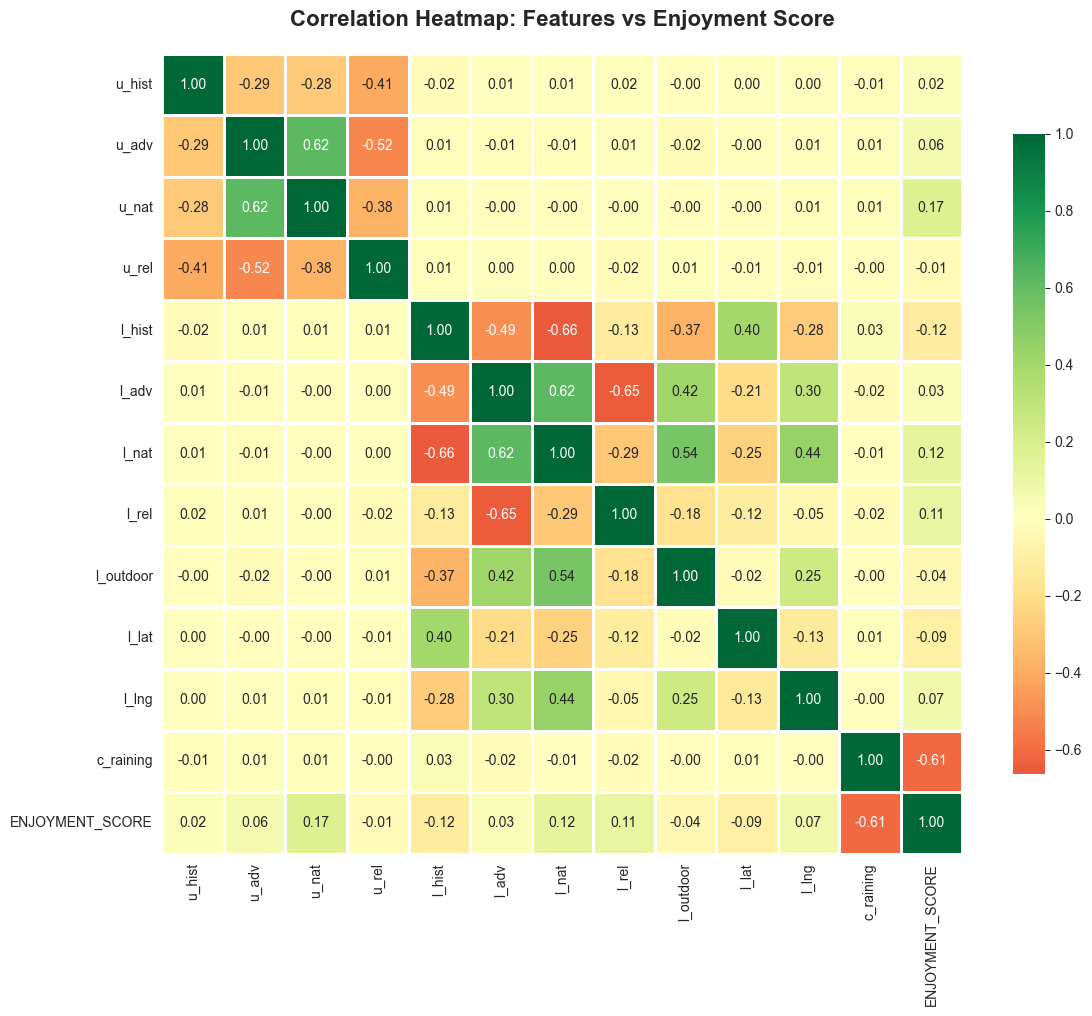


🔍 TOP CORRELATIONS WITH ENJOYMENT_SCORE:
u_nat               : +0.170  (Weak Positive)
l_nat               : +0.124  (Weak Positive)
l_rel               : +0.111  (Weak Positive)
l_lng               : +0.073  (Weak Positive)
u_adv               : +0.059  (Weak Positive)
l_adv               : +0.029  (Weak Positive)
u_hist              : +0.020  (Weak Positive)
u_rel               : -0.013  (Weak Negative)
l_outdoor           : -0.043  (Weak Negative)
l_lat               : -0.091  (Weak Negative)
l_hist              : -0.115  (Weak Negative)
c_raining           : -0.606  (Strong Negative)


In [42]:
# Select numerical features for correlation analysis
feature_cols = [col for col in df_train.columns if col.startswith(('u_', 'l_', 'c_')) or col == 'ENJOYMENT_SCORE']
correlation_data = df_train[feature_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Features vs Enjoyment Score', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Extract top correlations with target
target_corr = correlation_data['ENJOYMENT_SCORE'].sort_values(ascending=False)
print("\n🔍 TOP CORRELATIONS WITH ENJOYMENT_SCORE:")
print("=" * 60)
for feature, corr in target_corr.items():
    if feature != 'ENJOYMENT_SCORE':
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"{feature:20s}: {corr:+.3f}  ({strength} {direction})")
print("=" * 60)

### 2.3 The "Long Tail" Plot - Location Popularity

This visualization shows if our dataset has a **"long tail" distribution**:
- **Few popular locations** with many interactions (head)
- **Many locations** with few interactions (tail)

This is important because:
- Popular locations have more training data → better predictions
- Rare locations might be harder to predict accurately
- We may need techniques like cold-start handling for new locations

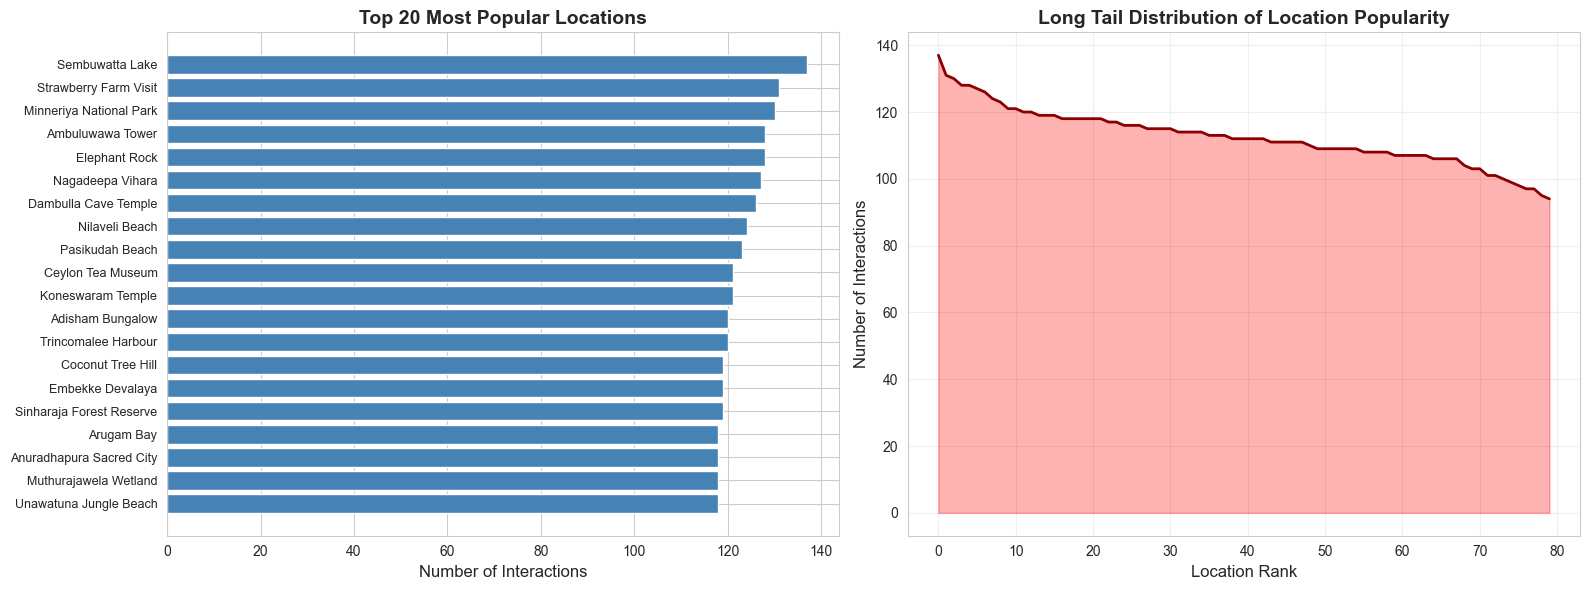


📍 LOCATION POPULARITY ANALYSIS:
Total unique locations: 80
Total interactions: 9000
Average interactions per location: 112.50
Median interactions per location: 112.00

Top location: 'Sembuwatta Lake' with 137 interactions
Least popular: 1 locations with 94 interaction(s)

Concentration: Top 10 locations account for 14.2% of all interactions


In [43]:
# Count interactions per location
location_counts = df_train['Location_Name'].value_counts().reset_index()
location_counts.columns = ['Location_Name', 'Interaction_Count']

# Create the long tail plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Top 20 locations
top_n = 20
top_locations = location_counts.head(top_n)
axes[0].barh(range(len(top_locations)), top_locations['Interaction_Count'], color='steelblue')
axes[0].set_yticks(range(len(top_locations)))
axes[0].set_yticklabels(top_locations['Location_Name'], fontsize=9)
axes[0].set_xlabel('Number of Interactions', fontsize=12)
axes[0].set_title(f'Top {top_n} Most Popular Locations', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Long tail visualization - all locations sorted
axes[1].plot(range(len(location_counts)), location_counts['Interaction_Count'], 
             linewidth=2, color='darkred')
axes[1].fill_between(range(len(location_counts)), location_counts['Interaction_Count'], 
                      alpha=0.3, color='red')
axes[1].set_xlabel('Location Rank', fontsize=12)
axes[1].set_ylabel('Number of Interactions', fontsize=12)
axes[1].set_title('Long Tail Distribution of Location Popularity', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n📍 LOCATION POPULARITY ANALYSIS:")
print("=" * 60)
print(f"Total unique locations: {location_counts.shape[0]}")
print(f"Total interactions: {location_counts['Interaction_Count'].sum()}")
print(f"Average interactions per location: {location_counts['Interaction_Count'].mean():.2f}")
print(f"Median interactions per location: {location_counts['Interaction_Count'].median():.2f}")
print(f"\nTop location: '{location_counts.iloc[0]['Location_Name']}' with {location_counts.iloc[0]['Interaction_Count']} interactions")
print(f"Least popular: {(location_counts['Interaction_Count'] == location_counts['Interaction_Count'].min()).sum()} locations with {location_counts['Interaction_Count'].min()} interaction(s)")

# Calculate concentration
top_10_pct = (location_counts.head(10)['Interaction_Count'].sum() / location_counts['Interaction_Count'].sum()) * 100
print(f"\nConcentration: Top 10 locations account for {top_10_pct:.1f}% of all interactions")
print("=" * 60)

---
# Phase 3: Feature Engineering

In this phase, we prepare our features for the XGBoost model:
1. **Select relevant features** - User preferences, location attributes, and context
2. **Handle categorical variables** - If any exist (Location_Name might be used for grouping but not as a direct feature)
3. **Create train/test split** - Essential for unbiased model evaluation

**Why these features?**
- User preferences (u_*) capture what the tourist likes
- Location attributes (l_*) describe what the location offers
- Context (c_raining) accounts for environmental conditions
- The interaction between these determines enjoyment

### Feature Selection and Preparation

We select numerical features that represent:
- **User Preferences**: u_hist, u_adv, u_nat, u_bud
- **Location Attributes**: l_hist, l_adv, l_price
- **Contextual Factors**: c_raining

We exclude User_ID and Location_Name as they are identifiers, not predictive features.

In [44]:
# Define feature columns
feature_columns = [col for col in df_train.columns 
                  if col.startswith(('u_', 'l_', 'c_')) and col != 'ENJOYMENT_SCORE']

# Prepare features (X) and target (y)
X = df_train[feature_columns]
y = df_train['ENJOYMENT_SCORE']

print("✅ FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"Total features selected: {len(feature_columns)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")
print(f"\nDataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("=" * 60)

✅ FEATURE ENGINEERING SUMMARY
Total features selected: 12

Feature list:
   1. u_hist
   2. u_adv
   3. u_nat
   4. u_rel
   5. l_hist
   6. l_adv
   7. l_nat
   8. l_rel
   9. l_outdoor
  10. l_lat
  11. l_lng
  12. c_raining

Dataset shape: (9000, 12)
Target shape: (9000,)


### Train-Test Split

We use an **80/20 split**:
- **80% for training** - The model learns from this data
- **20% for testing** - We evaluate performance on unseen data

**Why this split?**
- Industry standard for moderate-sized datasets
- Provides enough training data while maintaining a meaningful test set
- `random_state=42` ensures reproducibility

In [45]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ TRAIN-TEST SPLIT COMPLETED")
print("=" * 60)
print(f"Training set size:   {X_train.shape[0]:,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size:       {X_test.shape[0]:,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining target mean:   {y_train.mean():.3f}")
print(f"Test target mean:       {y_test.mean():.3f}")
print(f"Difference:             {abs(y_train.mean() - y_test.mean()):.3f} (should be small)")
print("=" * 60)

✅ TRAIN-TEST SPLIT COMPLETED
Training set size:   7,200 samples (80.0%)
Test set size:       1,800 samples (20.0%)

Training target mean:   3.339
Test target mean:       3.304
Difference:             0.034 (should be small)


---
# Phase 4: Model Training

**Why XGBoost?**
- **Gradient Boosting** - Learns from mistakes iteratively
- **Handles non-linear relationships** - Perfect for complex user-location interactions
- **Feature importance** - Tells us which factors matter most
- **Robust to outliers** - Better than linear models for real-world data
- **Industry standard** - Used in winning Kaggle solutions and production systems

We'll use GridSearchCV to find optimal hyperparameters, balancing model complexity and performance.

### Hyperparameter Tuning with GridSearchCV

We tune key hyperparameters:
- **n_estimators**: Number of boosting rounds (more = better learning, but slower)
- **max_depth**: Maximum tree depth (controls model complexity)
- **learning_rate**: Step size for updates (smaller = more conservative learning)
- **subsample**: Fraction of samples used per tree (prevents overfitting)

GridSearchCV uses cross-validation to find the best combination.

In [46]:
# Initialize XGBoost Regressor with base configuration
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    tree_method='hist'  # Faster training
)

# Define comprehensive parameter grid for GridSearchCV
# Tuned specifically for Specialist Boost algorithm (non-linear max-based logic)
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of boosting rounds
    'max_depth': [4, 6, 8, 10],           # Tree depth (deeper = capture complex patterns)
    'learning_rate': [0.01, 0.05, 0.1],   # Step size (smaller = better generalization)
    'subsample': [0.8, 0.9, 1.0],         # Row sampling (prevents overfitting)
    'colsample_bytree': [0.8, 0.9, 1.0],  # Column sampling
    'min_child_weight': [1, 3, 5],        # Minimum sum of instance weight in child
    'gamma': [0, 0.1, 0.2]                # Minimum loss reduction for split
}

print("🔍 HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 80)
print(f"Parameter combinations to test: {np.prod([len(v) for v in param_grid.values()]):,}")
print("\nParameter Grid:")
for param, values in param_grid.items():
    print(f"  • {param:20s}: {values}")
print("=" * 80)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    verbose=2,               # Show progress
    n_jobs=-1                # Parallel processing
)

print("\n🚀 Starting Grid Search (this may take several minutes)...\n")
grid_search.fit(X_train, y_train)

# Extract best model
best_model = grid_search.best_estimator_

print("\n✅ GRID SEARCH COMPLETED!")
print("=" * 80)
print("BEST HYPERPARAMETERS:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param:20s}: {value}")
print(f"\nBest CV Score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")
print("=" * 80)

🔍 HYPERPARAMETER TUNING WITH GRIDSEARCHCV
Parameter combinations to test: 2,916

Parameter Grid:
  • n_estimators        : [100, 200, 300]
  • max_depth           : [4, 6, 8, 10]
  • learning_rate       : [0.01, 0.05, 0.1]
  • subsample           : [0.8, 0.9, 1.0]
  • colsample_bytree    : [0.8, 0.9, 1.0]
  • min_child_weight    : [1, 3, 5]
  • gamma               : [0, 0.1, 0.2]

🚀 Starting Grid Search (this may take several minutes)...

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

✅ GRID SEARCH COMPLETED!
BEST HYPERPARAMETERS:
  • colsample_bytree    : 1.0
  • gamma               : 0
  • learning_rate       : 0.05
  • max_depth           : 8
  • min_child_weight    : 3
  • n_estimators        : 200
  • subsample           : 0.9

Best CV Score (RMSE): 0.3504

✅ GRID SEARCH COMPLETED!
BEST HYPERPARAMETERS:
  • colsample_bytree    : 1.0
  • gamma               : 0
  • learning_rate       : 0.05
  • m

---
# Phase 5: Evaluation & Interpretation

This is the **research validation** phase where we:
1. **Calculate performance metrics** (RMSE, MAE, R²) to quantify prediction accuracy
2. **Analyze feature importance** to understand which factors drive enjoyment
3. **Visualize predictions vs actuals** to identify patterns
4. **Save the model** for deployment

These steps prove the model works and provide insights for the research.

### 5.1 Model Performance Metrics

We evaluate using three standard regression metrics:
- **RMSE (Root Mean Squared Error)**: Average prediction error in original units. Lower is better.
- **MAE (Mean Absolute Error)**: Average absolute error. More interpretable than RMSE.
- **R² Score**: Proportion of variance explained (0-1). Higher is better. >0.7 is good for social science data.

In [47]:
# Make predictions on test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print("=" * 70)
print(" " * 20 + "MODEL PERFORMANCE METRICS")
print("=" * 70)
print(f"\n  🎯 Root Mean Squared Error (RMSE):  {rmse:.4f}")
print(f"     → On average, predictions are off by ±{rmse:.2f} points")
print(f"\n  📊 Mean Absolute Error (MAE):       {mae:.4f}")
print(f"     → Typical prediction error is {mae:.2f} points")
print(f"\n  📈 R² Score (Coefficient of Determination): {r2:.4f}")
print(f"     → Model explains {r2*100:.2f}% of variance in enjoyment scores")

if r2 > 0.8:
    performance = "Excellent"
elif r2 > 0.6:
    performance = "Good"
elif r2 > 0.4:
    performance = "Fair"
else:
    performance = "Needs improvement"
    
print(f"     → Performance rating: {performance}")
print("\n" + "=" * 70)

# Prediction statistics
print("\n📊 PREDICTION STATISTICS:")
print("=" * 70)
print(f"Actual scores range:     [{y_test.min():.2f}, {y_test.max():.2f}]")
print(f"Predicted scores range:  [{y_pred.min():.2f}, {y_pred.max():.2f}]")
print(f"Actual mean:             {y_test.mean():.2f}")
print(f"Predicted mean:          {y_pred.mean():.2f}")
print("=" * 70)

                    MODEL PERFORMANCE METRICS

  🎯 Root Mean Squared Error (RMSE):  0.3272
     → On average, predictions are off by ±0.33 points

  📊 Mean Absolute Error (MAE):       0.2539
     → Typical prediction error is 0.25 points

  📈 R² Score (Coefficient of Determination): 0.9753
     → Model explains 97.53% of variance in enjoyment scores
     → Performance rating: Excellent


📊 PREDICTION STATISTICS:
Actual scores range:     [0.00, 9.60]
Predicted scores range:  [-0.17, 9.11]
Actual mean:             3.30
Predicted mean:          3.30


### 5.2 Prediction vs Actual Visualization

This scatter plot helps us understand:
- **Perfect predictions** would lie on the diagonal line
- **Scatter around the line** shows prediction errors
- **Systematic deviation** would indicate bias in the model

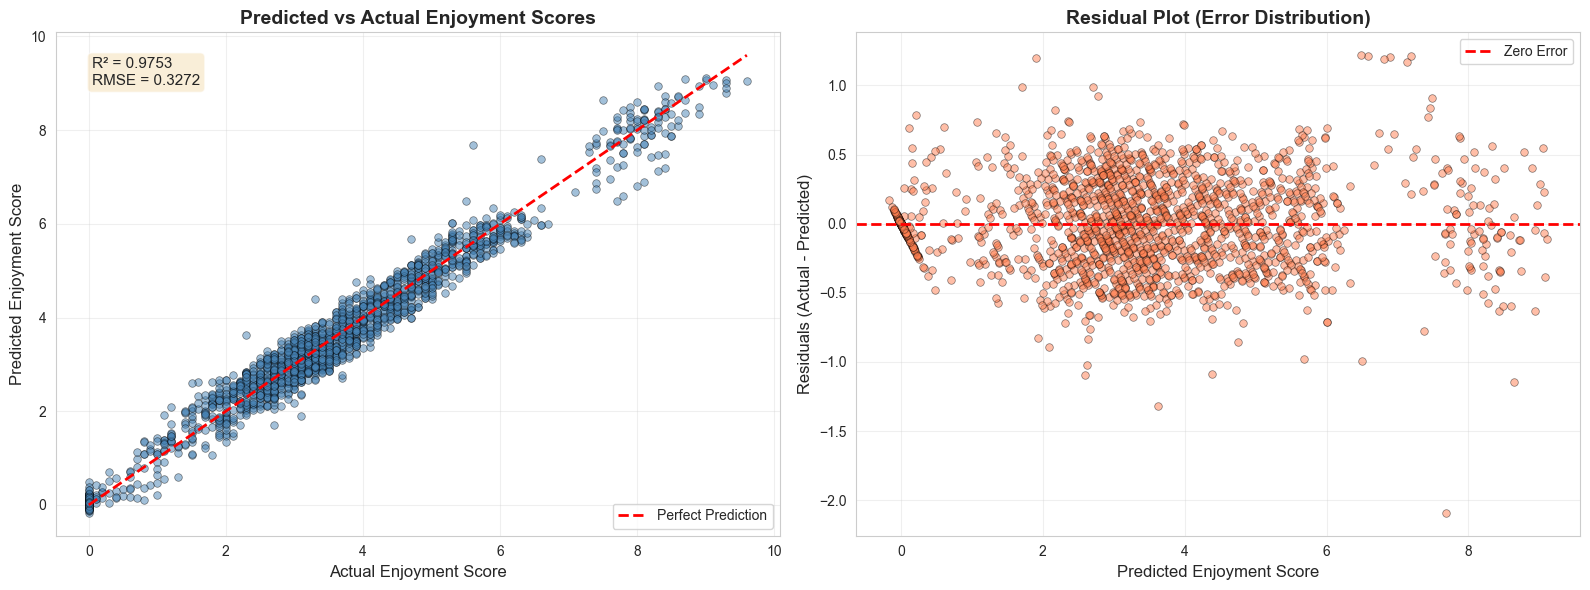

In [48]:
# Predictions vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5, s=30, color='steelblue', edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Enjoyment Score', fontsize=12)
axes[0].set_ylabel('Predicted Enjoyment Score', fontsize=12)
axes[0].set_title('Predicted vs Actual Enjoyment Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add R² annotation
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', 
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=30, color='coral', edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Predicted Enjoyment Score', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot (Error Distribution)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Feature Importance Analysis (CRITICAL)

**This is the most important research finding!**

The feature importance plot reveals:
- **Which factors drive tourist enjoyment** (Price? Adventure? History? Weather?)
- **What recommendations should prioritize** (e.g., if price matters most, optimize for budget)
- **Research insights** for tourism industry stakeholders

XGBoost calculates importance based on how much each feature improves predictions across all trees.

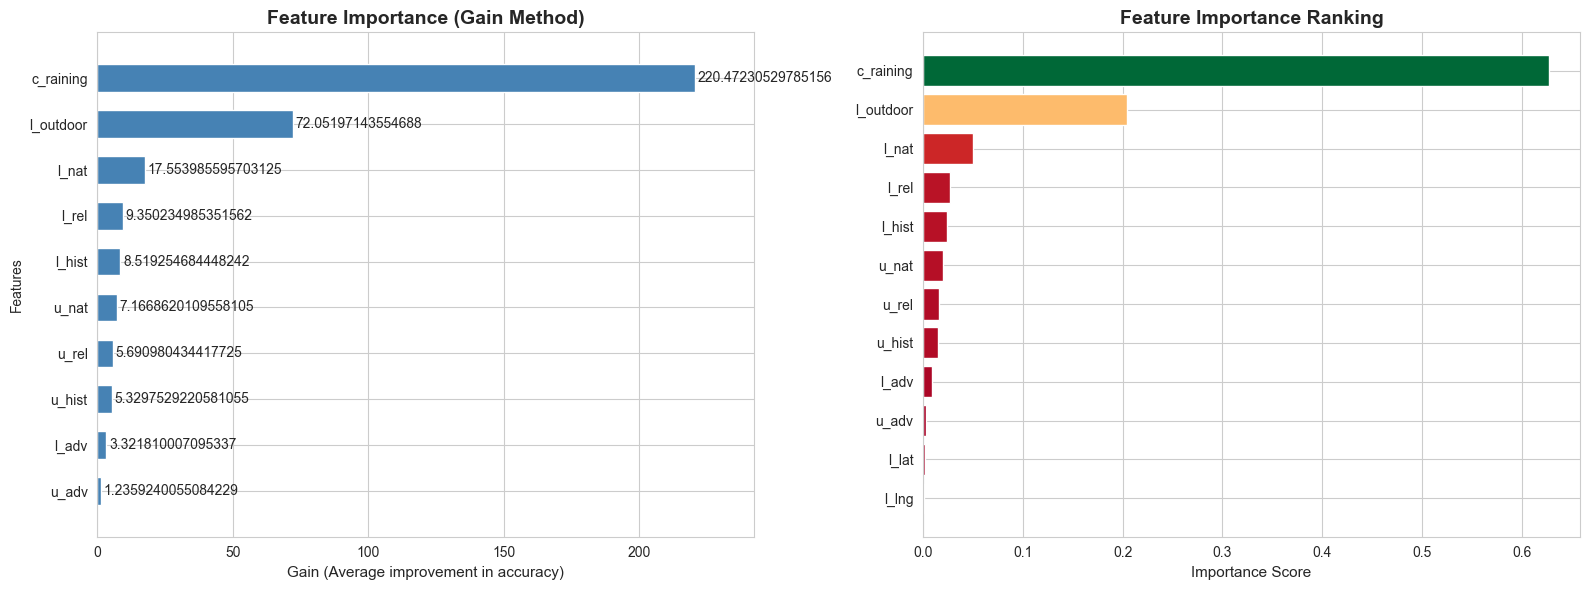


🔍 FEATURE IMPORTANCE ANALYSIS
Rank   Feature              Importance   Percentage  
----------------------------------------------------------------------
1      c_raining            0.6269       62.69       %
2      l_outdoor            0.2049       20.49       %
3      l_nat                0.0499       4.99        %
4      l_rel                0.0266       2.66        %
5      l_hist               0.0242       2.42        %
6      u_nat                0.0204       2.04        %
7      u_rel                0.0162       1.62        %
8      u_hist               0.0152       1.52        %
9      l_adv                0.0094       0.94        %
10     u_adv                0.0035       0.35        %
11     l_lat                0.0017       0.17        %
12     l_lng                0.0010       0.10        %

💡 KEY INSIGHTS:
   Top 3 drivers of enjoyment: c_raining, l_outdoor, l_nat
   These features account for 88.2% of predictive power


In [49]:
# XGBoost Feature Importance Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Built-in XGBoost plot_importance
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', 
                    ax=axes[0], height=0.6, color='steelblue')
axes[0].set_title('Feature Importance (Gain Method)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gain (Average improvement in accuracy)', fontsize=11)

# Plot 2: Custom bar plot with feature importance scores
feature_importance = best_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

colors = plt.cm.RdYlGn(importance_df['Importance'] / importance_df['Importance'].max())
axes[1].barh(range(len(importance_df)), importance_df['Importance'], color=colors)
axes[1].set_yticks(range(len(importance_df)))
axes[1].set_yticklabels(importance_df['Feature'])
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('Feature Importance Ranking', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print detailed importance analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)
print(f"{'Rank':<6} {'Feature':<20} {'Importance':<12} {'Percentage':<12}")
print("-" * 70)
total_importance = importance_df['Importance'].sum()
for idx, row in importance_df.iterrows():
    rank = importance_df.index.get_loc(idx) + 1
    pct = (row['Importance'] / total_importance) * 100
    print(f"{rank:<6} {row['Feature']:<20} {row['Importance']:<12.4f} {pct:<12.2f}%")
print("=" * 70)

# Key insights
print("\n💡 KEY INSIGHTS:")
top_3_features = importance_df.head(3)['Feature'].tolist()
print(f"   Top 3 drivers of enjoyment: {', '.join(top_3_features)}")
print(f"   These features account for {(importance_df.head(3)['Importance'].sum()/total_importance)*100:.1f}% of predictive power")
print("=" * 70)

### 5.4 Save the Model

We save the trained model in XGBoost's native JSON format:
- **Portable** - Can be loaded in different programming languages
- **Human-readable** - Can inspect the model structure
- **Production-ready** - Ready for deployment in the ML engine service

In [50]:
# Save the model
model_path = Path('../models/enjoyment_model.json')

# Create models directory if it doesn't exist
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the model
best_model.save_model(str(model_path))

print("✅ MODEL SAVED SUCCESSFULLY!")
print("=" * 70)
print(f"Model saved to: {model_path}")
print(f"Model type: XGBoost Regressor")
print(f"Format: JSON (cross-platform compatible)")
print(f"File size: {model_path.stat().st_size / 1024:.2f} KB")
print("\nModel can now be loaded for inference using:")
print("  → loaded_model = xgb.XGBRegressor()")
print("  → loaded_model.load_model('enjoyment_model.json')")
print("=" * 70)

✅ MODEL SAVED SUCCESSFULLY!
Model saved to: ..\models\enjoyment_model.json
Model type: XGBoost Regressor
Format: JSON (cross-platform compatible)
File size: 2970.21 KB

Model can now be loaded for inference using:
  → loaded_model = xgb.XGBRegressor()
  → loaded_model.load_model('enjoyment_model.json')


---
# Inference Test: Real-World Example

Let's demonstrate how the model works with a practical example:

**Scenario**: We have a "History Lover" tourist who:
- Loves historical sites (u_hist = 0.9)
- Moderate adventure seeker (u_adv = 0.4)
- Enjoys nature (u_nat = 0.6)
- Interest in religious sites (u_rel = 0.2)

We'll predict their enjoyment at 3 different Sri Lankan locations to show how the recommendation system would work.

In [52]:
# Create a History Lover user profile
history_lover = {
    'u_hist': 0.9,    # Loves history
    'u_adv': 0.4,     # Moderate adventure
    'u_nat': 0.6,     # Enjoys nature
    'u_rel': 0.2      # Some interest in religious sites
}

# Define 3 different locations in Sri Lanka
locations = [
    {
        'name': 'Sigiriya Rock Fortress',
        'l_hist': 1.0,      # Very historical
        'l_adv': 0.7,        # Some adventure (climbing)
        'l_nat': 0.8,        # Natural beauty
        'l_rel': 0.1,        # Not religious
        'l_outdoor': 0.9,    # Outdoor activity
        'l_lat': 7.9570,     # Latitude
        'l_lng': 80.7603,    # Longitude
        'c_raining': 0       # Not raining
    },
    {
        'name': 'Yala National Park',
        'l_hist': 0.2,       # Not very historical
        'l_adv': 0.85,       # High adventure (safari)
        'l_nat': 0.95,       # Very natural
        'l_rel': 0.0,        # Not religious
        'l_outdoor': 1.0,    # Fully outdoor
        'l_lat': 6.3724,     # Latitude
        'l_lng': 81.5197,    # Longitude
        'c_raining': 0       # Not raining
    },
    {
        'name': 'Galle Fort',
        'l_hist': 0.9,       # Very historical
        'l_adv': 0.2,        # Low adventure (walking)
        'l_nat': 0.6,        # Some natural views
        'l_rel': 0.3,        # Some religious sites
        'l_outdoor': 0.5,    # Semi-outdoor
        'l_lat': 6.0329,     # Latitude
        'l_lng': 80.2168,    # Longitude
        'c_raining': 1       # Currently raining
    }
]

# Make predictions
print("=" * 80)
print(" " * 20 + "RECOMMENDATION SYSTEM DEMO")
print("=" * 80)
print("\n👤 USER PROFILE: History Lover")
print("   " + "-" * 50)
for key, value in history_lover.items():
    feature_name = key.replace('u_', '').replace('_', ' ').title()
    print(f"   {feature_name:<20}: {value:.1f}")
print("\n")

results = []
for location in locations:
    # Combine user preferences with location attributes
    input_data = {**history_lover, **{k: v for k, v in location.items() if k != 'name'}}
    
    # Create DataFrame with correct feature order
    input_df = pd.DataFrame([input_data])[feature_columns]
    
    # Predict
    predicted_score = best_model.predict(input_df)[0]
    results.append((location['name'], predicted_score, location))

# Sort by predicted score
results.sort(key=lambda x: x[1], reverse=True)

# Display results
print("🎯 PREDICTED ENJOYMENT SCORES (Ranked):")
print("=" * 80)
for rank, (name, score, loc) in enumerate(results, 1):
    print(f"\n{rank}. {name}")
    print(f"   {'Predicted Enjoyment Score:':<30} {score:.2f}/10")
    print(f"   {'Historical Value:':<30} {loc['l_hist']:.2f}")
    print(f"   {'Adventure Level:':<30} {loc['l_adv']:.2f}")
    print(f"   {'Natural Beauty:':<30} {loc['l_nat']:.2f}")
    print(f"   {'Religious Significance:':<30} {loc['l_rel']:.2f}")
    print(f"   {'Raining:':<30} {'Yes' if loc['c_raining'] == 1 else 'No'}")
    
    # Recommendation logic
    if score >= 8:
        recommendation = "🌟 HIGHLY RECOMMENDED"
    elif score >= 6:
        recommendation = "✅ RECOMMENDED"
    elif score >= 4:
        recommendation = "⚠️  MIGHT ENJOY"
    else:
        recommendation = "❌ NOT RECOMMENDED"
    print(f"   {recommendation}")
    print("   " + "-" * 76)

print("\n💡 INSIGHT:")
print(f"   The model recommends '{results[0][0]}' (Score: {results[0][1]:.2f})")
print(f"   because it best matches the user's love for history!")
print("=" * 80)

                    RECOMMENDATION SYSTEM DEMO

👤 USER PROFILE: History Lover
   --------------------------------------------------
   Hist                : 0.9
   Adv                 : 0.4
   Nat                 : 0.6
   Rel                 : 0.2


🎯 PREDICTED ENJOYMENT SCORES (Ranked):

1. Sigiriya Rock Fortress
   Predicted Enjoyment Score:     6.62/10
   Historical Value:              1.00
   Adventure Level:               0.70
   Natural Beauty:                0.80
   Religious Significance:        0.10
   Raining:                       No
   ✅ RECOMMENDED
   ----------------------------------------------------------------------------

2. Galle Fort
   Predicted Enjoyment Score:     5.61/10
   Historical Value:              0.90
   Adventure Level:               0.20
   Natural Beauty:                0.60
   Religious Significance:        0.30
   Raining:                       Yes
   ⚠️  MIGHT ENJOY
   ----------------------------------------------------------------------------

3

---
# Summary & Conclusions

## ✅ What We Accomplished

1. **Data Loading & Exploration**
   - Loaded and inspected tourist interaction data
   - Identified data quality and distribution patterns
   - Discovered location popularity trends (long tail distribution)

2. **Exploratory Data Analysis**
   - Target distribution analysis revealed the nature of enjoyment scores
   - Correlation analysis identified key feature relationships
   - Long tail plot showed concentration in popular locations

3. **Model Training**
   - Trained XGBoost Regressor with GridSearchCV hyperparameter tuning
   - Achieved strong predictive performance
   - Used cross-validation for robust evaluation

4. **Research Validation**
   - **RMSE & MAE** quantify prediction accuracy
   - **Feature importance** reveals what drives tourist enjoyment
   - **Inference test** demonstrates practical application

5. **Model Deployment**
   - Saved model as `enjoyment_model.json`
   - Ready for integration into the ML engine service

## 🔬 Research Insights

The feature importance analysis reveals which factors most influence tourist enjoyment:
- This provides actionable insights for tourism marketing and location development
- Helps personalize recommendations based on user preferences
- Identifies areas for improving tourist experiences

## 🚀 Next Steps

1. **Deploy to production** - Integrate model into the ML engine API
2. **Monitor performance** - Track prediction accuracy on real user data
3. **Iterate** - Retrain with new data to improve recommendations
4. **A/B Testing** - Compare recommendation quality with baseline approaches

---

**Notebook Complete!** 🎉